In [1]:
#import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# Step 1: Download the MNIST dataset
torchvision.datasets.MNIST(root='./data', train=True, download=True)
torchvision.datasets.MNIST(root='./data', train=False, download=True)

# Step 2: Load the raw MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.51MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



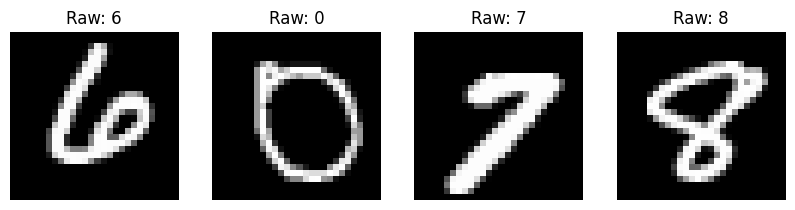

In [4]:
# Visualize the datasets
def show_images(images, labels, label_header="True"):
    figure = plt.figure(figsize=(10, 10))
    rows, cols = 1, 4
    for i in range(1, rows*cols+1):
        figure.add_subplot(rows, cols, i)
        plt.axis(False)
        plt.title(f"{label_header}: {labels[i-1].item()}")
        plt.imshow(images[i-1].permute(1, 2, 0), cmap='gray')

    plt.show()

# Get a batch of images and show
images, labels = next(iter(trainloader))
show_images(images, labels, label_header="Raw")

In [5]:
# Step 3: Preprocessing Step: Normalization and Data Augmentation
transform_train = transforms.Compose([
    transforms.RandomRotation(10),  # Randomly rotate the image by 10 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Random translation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize the same way for test set
])

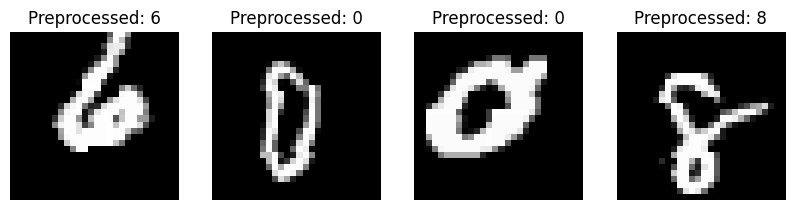

In [6]:
# Step 4: Load the MNIST dataset with preprocessing applied
trainset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Visualize Some Preprocessed Images
preprocessed_images, preprocessed_labels = next(iter(trainloader))
show_images(preprocessed_images, preprocessed_labels, label_header="Preprocessed")

In [7]:
#import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [8]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 1 input channel (grayscale), 32 filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32 input channels, 64 filters
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer with 2x2 filter
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pooling
        x = x.view(-1, 64 * 7 * 7)  # Flatten the tensor
        x = F.relu(self.fc1(x))  # FC1 -> ReLU
        x = self.fc2(x)  # Output layer
        return x

# Initialize model, criterion, and optimizer
cnn_model = CNN()
criterion = nn.CrossEntropyLoss()  # Cross entropy loss
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)  # Adam optimizer

In [9]:
# Training function
def train_cnn(model, trainloader, criterion, optimizer, epochs=10):
    model.train()    # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in trainloader:
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass and optimization
            optimizer.step()
            running_loss += loss.item()  # Statistics
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Print statistics
        epoch_loss = running_loss / len(trainloader)
        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Training Accuracy: {accuracy:.2f}%")

In [10]:
# Evaluation function
def evaluate_cnn(model, testloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():  # Disable gradient calculation for inference
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())  # Convert lists to numpy arrays
            all_preds.extend(predicted.cpu().numpy())

    # Compute evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average="weighted") * 100
    recall = recall_score(all_labels, all_preds, average="weighted") * 100
    f1 = f1_score(all_labels, all_preds, average="weighted") * 100

    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1 Score: {f1:.2f}%")

In [11]:
# Train the CNN model
train_cnn(cnn_model, trainloader, criterion, optimizer, epochs=10)

# Evaluate the CNN model on the test set
evaluate_cnn(cnn_model, testloader)

Epoch [1/10], Loss: 0.2955, Training Accuracy: 90.74%
Epoch [2/10], Loss: 0.0947, Training Accuracy: 97.08%
Epoch [3/10], Loss: 0.0709, Training Accuracy: 97.84%
Epoch [4/10], Loss: 0.0599, Training Accuracy: 98.17%
Epoch [5/10], Loss: 0.0534, Training Accuracy: 98.37%
Epoch [6/10], Loss: 0.0469, Training Accuracy: 98.56%
Epoch [7/10], Loss: 0.0428, Training Accuracy: 98.66%
Epoch [8/10], Loss: 0.0402, Training Accuracy: 98.73%
Epoch [9/10], Loss: 0.0371, Training Accuracy: 98.81%
Epoch [10/10], Loss: 0.0356, Training Accuracy: 98.88%
Test Accuracy: 99.22%
Precision: 99.22%
Recall: 99.22%
F1 Score: 99.22%
